In [1]:
import os
import re
import math
import random
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.attention.flex_attention import flex_attention, create_block_mask
import triton
import triton.language as tl
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython import display
torch.manual_seed(69)
torch.set_printoptions(profile="short", sci_mode=False, linewidth=100000)
torch.set_float32_matmul_precision('high')
# this script is configured to run on a RTX 3060 12GB GPU. you'll want to adjust the model sizes and batch sizes for other devices
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 50
plt.rcParams['axes.grid'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
device

device(type='cuda')

# Data Prep

In [2]:
# we use this 40mb file of concatenated anime subtitles as our dataset
# just the right size for toy experiments like this I think
with open('animesubs.txt', 'r', encoding='latin') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

length of dataset in characters:  39526018


In [3]:
print(text[:500])

Open your mind. Open your mind.

Far beyond the deep blue Earth, you and I shall meet...

AH! MY GODDESS

A snow-white feather comes fluttering down, swaying gently in the air.

Without holding back, I want to envelope you, my one and only love.

I know I have the power to protect the one I love, right here in my hands.

Open your mind. Just as I've always dreamed.

Let the wind carry off your hopes, faraway.

I have wings nobody can see. Look, you have them, too.

They'll take us to where we ca


In [4]:
# remove japanese characters
text = ''.join(filter(lambda character:ord(character) < 0x3000, text))

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("unique characters:", vocab_size, ''.join(chars))

unique characters: 86 
 !'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|


In [6]:
# yes, all language models will be character level, which isn't ideal but it's good for simplicity
# very simple tokenizer
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
# add special token for padding
stoi[''] = len(stoi)
itos[len(itos)] = ''
print(stoi)
print(itos)
encode = lambda s: [stoi[ch] for ch in s]
decode = lambda l: ''.join([itos[i] for i in l])
print("encoded:", encode(text[:20]))
print("decoded:", decode(encode(text[:20])))
vocab_size = len(itos)
print("vocab size:", vocab_size)

{'\n': 0, ' ': 1, '!': 2, "'": 3, '(': 4, ')': 5, '*': 6, '+': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '<': 24, '=': 25, '>': 26, '?': 27, '@': 28, 'A': 29, 'B': 30, 'C': 31, 'D': 32, 'E': 33, 'F': 34, 'G': 35, 'H': 36, 'I': 37, 'J': 38, 'K': 39, 'L': 40, 'M': 41, 'N': 42, 'O': 43, 'P': 44, 'Q': 45, 'R': 46, 'S': 47, 'T': 48, 'U': 49, 'V': 50, 'W': 51, 'X': 52, 'Y': 53, 'Z': 54, '[': 55, ']': 56, '_': 57, 'a': 58, 'b': 59, 'c': 60, 'd': 61, 'e': 62, 'f': 63, 'g': 64, 'h': 65, 'i': 66, 'j': 67, 'k': 68, 'l': 69, 'm': 70, 'n': 71, 'o': 72, 'p': 73, 'q': 74, 'r': 75, 's': 76, 't': 77, 'u': 78, 'v': 79, 'w': 80, 'x': 81, 'y': 82, 'z': 83, '|': 84, '\x94': 85, '': 86}
{0: '\n', 1: ' ', 2: '!', 3: "'", 4: '(', 5: ')', 6: '*', 7: '+', 8: ',', 9: '-', 10: '.', 11: '/', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '5', 18: '6', 19: '7', 20: '8', 21: '9', 22: ':', 23: ';', 24: '<', 25: '=

In [7]:
data = torch.tensor(encode(text), dtype=torch.int64)
data.shape

torch.Size([39526018])

In [8]:
data[:100]

tensor([43, 73, 62, 71,  1, 82, 72, 78, 75,  1, 70, 66, 71, 61, 10,  1, 43, 73, 62, 71,  1, 82, 72, 78, 75,  1, 70, 66, 71, 61, 10,  0,  0, 34, 58, 75,  1, 59, 62, 82, 72, 71, 61,  1, 77, 65, 62,  1, 61, 62, 62, 73,  1, 59, 69, 78, 62,  1, 33, 58, 75, 77, 65,  8,  1, 82, 72, 78,  1, 58, 71, 61,  1, 37,  1, 76, 65, 58, 69, 69,  1, 70, 62, 62, 77, 10, 10, 10,  0,  0, 29, 36,  2,  1, 41, 53,  1, 35, 43, 32])

In [9]:
n = int(len(data) * 0.99)
train_data = data[:n]
val_data = data[n:]
print(train_data.shape, val_data.shape)

torch.Size([39130757]) torch.Size([395261])


In [10]:
seq_len = 8
train_data[:seq_len+1]

tensor([43, 73, 62, 71,  1, 82, 72, 78, 75])

In [11]:
def get_batch(split, seq_len, batch_size=4):
    # generate a small batch of data of inputs x and targets y
    # targets are just inputs shifted by 1
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - seq_len, (batch_size,))
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:i+seq_len+1] for i in ix])
    return x.to(device), y.to(device)

xb, yb = get_batch('train', 64, 2)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([2, 64])
tensor([[64,  1, 72, 78, 75,  1, 66, 71, 77, 62, 75, 71, 76, 65, 66, 73, 76, 10,  0,  0, 48, 65, 62,  1, 71, 66, 64, 65, 77,  1, 37, 66, 61, 58,  1, 64, 72, 77,  1, 77, 65, 62,  1, 75, 62, 76, 78, 69, 77, 76,  1, 72, 63,  1, 77, 65, 62,  1, 62, 81, 58, 70, 66, 71],
        [62, 70,  2,  0,  0, 37, 77,  1, 69, 72, 72, 68, 76,  1, 69, 66, 68, 62,  1, 80, 62,  1, 77, 72, 72, 68,  1, 60, 58, 75, 62,  1, 72, 63,  1, 77, 65, 62, 70, 10,  0,  0, 48, 65, 72, 76, 62,  1, 64, 78, 82, 76,  1, 80, 62, 75, 62,  1, 66, 71, 60, 75, 62, 61]], device='cuda:0')
targets:
torch.Size([2, 64])
tensor([[ 1, 72, 78, 75,  1, 66, 71, 77, 62, 75, 71, 76, 65, 66, 73, 76, 10,  0,  0, 48, 65, 62,  1, 71, 66, 64, 65, 77,  1, 37, 66, 61, 58,  1, 64, 72, 77,  1, 77, 65, 62,  1, 75, 62, 76, 78, 69, 77, 76,  1, 72, 63,  1, 77, 65, 62,  1, 62, 81, 58, 70, 66, 71, 58],
        [70,  2,  0,  0, 37, 77,  1, 69, 72, 72, 68, 76,  1, 69, 66, 68, 62,  1, 80, 62,  1, 77, 72, 72, 68,  1, 60, 58, 75, 62

# Training Prep

In [12]:
# Make all steps, sequence lengths, and batch size the same
total_steps = 5000
seq_len = 256
batch_size = 256 # these are small models so we can use large batch sizes to fully utilize the GPU
# should cover around 2x the dataset
total_steps * seq_len * batch_size

327680000

In [13]:
def train(model, optimizer, seq_len, batch_size, total_steps, val_steps=10, val_interval=50):
    losses = []
    val_losses = []
    # live plot
    fig, ax = plt.subplots()
    dh = display.display(fig, display_id=True)
    for steps in (bar := tqdm(range(total_steps))):  # increase number of steps for good results...
        # sample a batch of data
        xb, yb = get_batch('train', seq_len=seq_len, batch_size=batch_size)

        # evaluate the loss
        logits, loss = model(xb, yb)

        # backprop
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        bar.set_description(f"loss: {loss.item():.2f}, val loss: {val_losses[-1] if val_losses else 0:.2f}")
        losses.append(loss.item())
        if steps % val_interval == 0:
            # Calculate validation loss
            with torch.no_grad():
                val_loss = 0
                for _ in range(val_steps):
                    xb, yb = get_batch('val', seq_len=seq_len, batch_size=batch_size)
                    _, loss = model(xb, yb)
                    val_loss += loss.item()
                val_loss /= val_steps
                val_losses.append(val_loss)
            ax.clear()
            ax.plot(losses, color='blue', label='train loss', alpha=0.7)
            ax.plot(range(0, len(losses), val_interval), val_losses, color='red', label='val loss', alpha=0.7)
            ax.set_ylim(1, 4)
            ax.legend()
            dh.update(fig)
    print('final loss:', loss.item(), 'final val loss:', val_loss)

In [14]:
# Measure post training perplexity on validation set
# Create function that receives a model, context length, and PPL sequence length, and returns the perplexity
# The PPL sequence length is the number of characters the function uses to calculate the perplexity
# We take the logits and calculate the cross entropy loss from scratch, then exponentiate it to get the perplexity
# not only that, but we want the models to do this in actual inference
def perplexity(model, seq_len, ppl_seq_len, batch_size=128, val_steps=1000):
    with torch.no_grad():
        val_loss = 0
        for _ in tqdm(range(val_steps)):
            xb, yb = get_batch('val', seq_len=seq_len, batch_size=batch_size)
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                logits, _ = model(xb, yb)
            logits = logits.reshape(batch_size, seq_len, vocab_size)
            logits = logits[:, :ppl_seq_len]
            yb = yb[:, :ppl_seq_len]
            # flatten logits and targets
            logits = logits.reshape(batch_size*ppl_seq_len, vocab_size)
            yb = yb.reshape(batch_size*ppl_seq_len)
            # calculate cross entropy loss from scratch
            loss = F.cross_entropy(logits, yb)
            val_loss += loss.item()
        val_loss /= val_steps
        ppl = torch.exp(torch.tensor(val_loss))
        return ppl.item(), val_loss

# Transformers

## Classic Transformer

In [15]:
class TransformerConfig:
    def __init__(self, vocab_size, seq_len, embed_size, head_num, layer_num):
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_size = embed_size
        self.head_num = head_num
        self.layer_num = layer_num

def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis.to(device)

def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    # freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    q_shape = [d if i == xq_.ndim - 2 or i == xq_.ndim - 1 else 1 for i, d in enumerate(xq_.shape)]
    k_shape = [d if i == xq_.ndim - 2 or i == xk_.ndim - 1 else 1 for i, d in enumerate(xk_.shape)]
    T_q = xq_.shape[-2] 
    q_freqs_cis = freqs_cis[-T_q:].view(*q_shape)
    k_freqs_cis = freqs_cis.view(*k_shape)
    xq_out = torch.view_as_real(xq_ * q_freqs_cis).flatten(xq.dim() - 1)
    xk_out = torch.view_as_real(xk_ * k_freqs_cis).flatten(xq.dim() - 1)
    return xq_out.type_as(xq), xk_out.type_as(xk)

class RMSNorm(torch.nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight
    
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.lin_1 = nn.Linear(config.embed_size, config.embed_size*4)
        self.lin_2 = nn.Linear(config.embed_size*4, config.embed_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lin_1(x)
        x = self.relu(x)
        x = self.lin_2(x)
        return x

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention with AliBi in parallel """
    def __init__(self, config):
        super().__init__()
        self.seq_len = config.seq_len
        self.head_num = config.head_num
        self.head_size = config.embed_size // config.head_num
        self.key = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.query = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.value = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.o = nn.Linear(config.embed_size, config.embed_size)
        # block_mask for FlexAttention
        def causal(b, h, q_idx, kv_idx):
            causal_mask = q_idx >= kv_idx
            return causal_mask
        self.causal_mask = create_block_mask(causal, B=None, H=None, Q_LEN=config.seq_len, KV_LEN=config.seq_len)
        self.freqs_cis = precompute_freqs_cis(config.embed_size//config.head_num, config.seq_len)
        self.register_buffer('tril', torch.tril(torch.ones(config.seq_len, config.seq_len)))

    def forward(self, x, kv_cache=None):
        B, T, C = x.shape
        _, _, T_past, _ = kv_cache[0].shape if kv_cache is not None and kv_cache[0] is not None else (0, 0, 0, 0)
        q = self.query(x) # (B,T,C)
        k = self.key(x)   # (B,T,C)
        v = self.value(x) # (B,T,C)

        # Split into heads
        q = q.view(B, T, self.head_num, self.head_size).transpose(1, 2) # (B, H, T, C/H)
        k = k.view(B, T, self.head_num, self.head_size).transpose(1, 2) # (B, H, T, C/H)
        v = v.view(B, T, self.head_num, self.head_size).transpose(1, 2) # (B, H, T, C/H)

        if kv_cache is not None:
            k_past, v_past = kv_cache
            if k_past is not None:
                k = torch.cat((k_past, k), dim=2)
                v = torch.cat((v_past, v), dim=2)
            if k.shape[-2] > self.seq_len:
                k = k[:, :, -self.seq_len:]
                v = v[:, :, -self.seq_len:]
            kv_cache = (k, v)
        T_k = k.shape[-2]
        q, k = apply_rotary_emb(q, k, self.freqs_cis[:T_k])

        if T == self.seq_len:
            out = flex_attention(q, k, v, block_mask=self.causal_mask)
        else:
            # compute attention scores ("affinities")
            wei = q @ k.transpose(-2,-1) # (B, H, 1, C/H) @ (B, H, C/H, T) -> (B, H, 1, T)
            wei = wei * self.head_size ** -0.5 # scaled attention
            wei = wei.masked_fill(self.tril[T_k-T:T_k, T_k-T:T_k] == 0, float('-inf')) # (B, T, T)
            wei = F.softmax(wei, dim=-1) # (B, H, T, T)
            # apply attention to values
            out = wei @ v # (B, H, 1, T) @ (B, H, T, C/H) -> (B, H, 1, C/H)

        out = out.transpose(1, 2).contiguous().view(B, T, C) # (B, H, T, C/H) -> (B, T, H, C/H) -> (B, T, C)
        out = self.o(out)
        return out, kv_cache

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.sa_heads = MultiHeadAttention(config)
        self.ff_layer = FeedForward(config)
        self.sa_norm = RMSNorm(config.embed_size)
        self.ff_norm = RMSNorm(config.embed_size)
    
    def forward(self, x, kv_cache=None):
        a, kv_cache = self.sa_heads(self.sa_norm(x), kv_cache)
        h = x + a
        o = h + self.ff_layer(self.ff_norm(h))
        return o, kv_cache
    
class TransformerLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_num = config.layer_num
        self.head_num = config.head_num
        self.seq_len = config.seq_len
        # embed raw tokens to a lower dimensional embedding with embed_size
        self.token_embedding_table = nn.Embedding(config.vocab_size, config.embed_size)
        # Language Modelling (?) Head is a standard linear layer to go from 
        # embeddings back to logits of vocab_size
        self.lm_head = nn.Linear(config.embed_size, config.vocab_size)
        # transformer blocks
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.layer_num)])

    def forward(self, idx, targets=None, kv_cache=None):
        B, T = idx.shape
        _, _, T_past, _ = kv_cache[0][0].shape if kv_cache is not None and kv_cache[0][0] is not None else (0, 0, 0, 0)
        # idx and targets are both (B,T) tensor of integers
        tok_embd = self.token_embedding_table(idx) # (B,T,C)
        x = tok_embd
        # go through blocks
        for i, block in enumerate(self.blocks):
            x, cache = block(x, None if kv_cache is None else kv_cache[i])
            if kv_cache is not None:
                kv_cache[i] = cache
        # get logits with linear layer
        logits = self.lm_head(x) # (B,T,V)
        
        if targets is None:
            loss = None
        else:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1, use_cache=True):
        if use_cache:
            # initialize key-value cache
            kv_cache = [(None, None) for _ in range(self.layer_num)]
            # idx is (B, T) array of indices in the current context
            # crop idx to the last seq_len tokens
            idx_context = idx[:, -self.seq_len:]
            for _ in range(max_new_tokens):
                # get the predictions
                logits, loss = self(idx_context, kv_cache=kv_cache)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
                # since we have kv cache, only need to pass new token
                idx_context = idx_next
            return idx
        else:
            # idx is (B, T) array of indices in the current context
            for _ in range(max_new_tokens):
                #crop idx to the last seq_len tokens
                idx_context = idx[:, -self.seq_len:]
                # get the predictions
                logits, loss = self(idx_context)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            return idx

In [16]:
# Test forward pass
config = TransformerConfig(
    vocab_size=vocab_size,
    seq_len=seq_len,
    embed_size=256,
    head_num=4,
    layer_num=6
)
m = TransformerLM(config)
m.to(device)
xb, yb = get_batch('train', 5, 1)
logits, loss = m(xb, yb)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

4775511

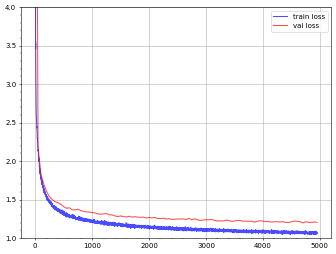

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/zaydz/.main-venv/lib/python3.12/site-packages/torch/_inductor/lowering.py:1713: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(


final loss: 1.0745582580566406 final val loss: 1.2047595977783203


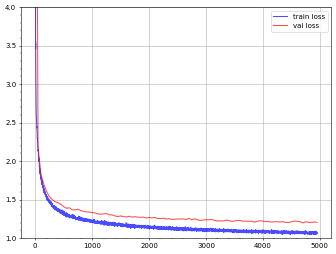

In [17]:
# training!
model = TransformerLM(config)
model = torch.compile(model)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, optimizer, seq_len, batch_size, total_steps)

In [18]:
# Save
torch.save(model.state_dict(), 'models/TransformerLM.pt')

In [19]:
# Load model
model = TransformerLM(config)
model = torch.compile(model)
model.load_state_dict(torch.load('models/TransformerLM.pt'))
model.to(device)

/tmp/ipykernel_28159/96251971.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/TransformerLM.pt'))


OptimizedModule(
  (_orig_mod): TransformerLM(
    (token_embedding_table): Embedding(87, 256)
    (lm_head): Linear(in_features=256, out_features=87, bias=True)
    (blocks): ModuleList(
      (0-5): 6 x Block(
        (sa_heads): MultiHeadAttention(
          (key): Linear(in_features=256, out_features=256, bias=False)
          (query): Linear(in_features=256, out_features=256, bias=False)
          (value): Linear(in_features=256, out_features=256, bias=False)
          (o): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff_layer): FeedForward(
          (lin_1): Linear(in_features=256, out_features=1024, bias=True)
          (lin_2): Linear(in_features=1024, out_features=256, bias=True)
          (relu): ReLU()
        )
        (sa_norm): RMSNorm()
        (ff_norm): RMSNorm()
      )
    )
  )
)

In [20]:
# calculate perplexity
ppl, loss = perplexity(model, seq_len, seq_len)
print("perplexity:", ppl, "loss:", loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

perplexity: 3.334986925125122 loss: 1.20446875


In [21]:
model.eval()
idx = encode("You will never")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), max_new_tokens=1000, temperature=0.5, use_cache=True)[0].tolist()))

tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75]])
You will never decide what to do if you will take to see me.

I don't mind it.

I wonder if it'll be to make it to the bunny today.

I wonder if that happens at all.

If I can continue fighting something that would be the memories of the moment.

But it doesn't matter if I heard that.

I don't want to hear that for you.

I wonder if I can become this possible.

I'm sure that I would like to hear you.

I wonder if the things would look like this...

I think it's the only one who continues to take a picture of him.

Where's he going home?

If that's the worst true power to continue the entire training companies,

I would have come to the train somewhere seriously.

What do you think there are someone who can come to the country of the world line before we met.

The next step is the power of the country with the moment I came to the prize again.

I am the super bad and she could say that.

I can explode the world from the 